In [1]:
%load_ext autoreload
%autoreload 2

# Imports and Plot Settings

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from ode_solver import solve_twa_batched_stats

W1226 11:18:59.174503   20389 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1226 11:18:59.176617   19894 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [3]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Closed System Test

In [4]:
def hamiltonian(s, args):
    omega, gamma = args
    return omega*s[0]

n_trajectories = int(1e5)
batch_size = int(1e4)
params = (1.0, 0) # Omega=1.0, Gamma=0.5
key = jax.random.PRNGKey(42)
t_eval = jnp.linspace(0, 20, int(1e3))

mean_s, var_s = solve_twa_batched_stats(
    key, n_trajectories, batch_size, t_eval, 
    hamiltonian, [], params
)

Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


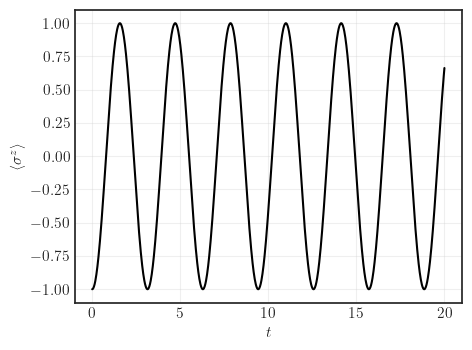

In [5]:
fig, ax = plt.subplots(figsize=(5, 3.8))
plt.plot(t_eval, mean_s[:,2], color = 'k')
plt.ylabel(r'$\langle \sigma^z\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.show()

# Open System Test

In [6]:
def hamiltonian(s, args):
    omega, gamma = args
    return omega*s[0]

def spontaneous_emission(s, args):
    omega, gamma = args
    # Note: The factor 0.5 is crucial to match standard Lindblad rate Gamma
    return (jnp.sqrt(gamma) * 0.5) * (s[0] - 1j * s[1])

n_trajectories = int(1e5)
batch_size = int(1e4)
params = (1.0, 0.15) # Omega=1.0, Gamma=0.5
key = jax.random.PRNGKey(42)
t_eval = jnp.linspace(0, 20, int(1e3))

mean_s, var_s = solve_twa_batched_stats(
    key, n_trajectories, batch_size, t_eval, 
    hamiltonian, [spontaneous_emission], params
)

Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 10/10 [01:36<00:00,  9.65s/it]


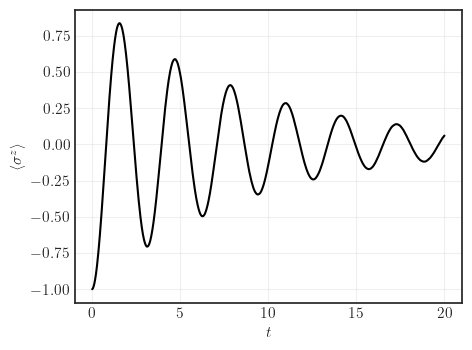

In [8]:
fig, ax = plt.subplots(figsize=(5, 3.8))
plt.plot(t_eval, mean_s[:,2], color = 'k')
plt.ylabel(r'$\langle \sigma^z\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.show()